# Explore flight delay data wrt day of week

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

# 0. Load and process data

In [3]:
# Load data
from flightdelay.fld import io as flio
airlines_df, airports_df, flights_df = flio.load_data()

### Restrict analysis to airports with at least 20 flights/day

In [4]:
# Find all unique airports
all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

# Determine number of flights for the origin airport
Nflights_orig = np.zeros(len(airport_inverse))
for i in range(len(all_airports)):
    Nflights_orig[np.where(airport_inverse==i)] = airport_count[i]
    
flights_df = flights_df.loc[flights_df.index[Nflights_orig>=7300]]

### Remove cancelled flights

In [5]:
# Filter data to columns of interest (others have NaNs)
keys_keep = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']
flights_df = flights_df[keys_keep]

flights_df = flights_df.dropna()
flights_df.head()

MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER ORIGIN_AIRPORT  \
0      1    1            4      AS             98      N407AS            ANC   
1      1    1            4      AA           2336      N3KUAA            LAX   
2      1    1            4      US            840      N171US            SFO   
3      1    1            4      AA            258      N3HYAA            LAX   
4      1    1            4      AS            135      N527AS            SEA   

  DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME      ...        \
0                 SEA                    5          2354.0      ...         
1                 PBI                   10             2.0      ...         
2                 CLT                   20            18.0      ...         
3                 MIA                   20            15.0      ...         
4                 ANC                   25            24.0      ...         

   WHEELS_OFF  SCHEDULED_TIME  ELAPSED_TIME  AIR_TIME  DISTANCE  WHEELS_ON  \
0        15.0           205.0         194.0     169.0      1448      404.0   
1        14.0           280.0         279.0     263.0      2330      737.0   
2        34.0           286.0         293.0     266.0      2296      800.0   
3        30.0           285.0         281.0     258.0      2342      748.0   
4        35.0           235.0         215.0     199.0      1448      254.0   

   TAXI_IN  SCHEDULED_ARRIVAL  ARRIVAL_TIME  ARRIVAL_DELAY  
0      4.0                430         408.0          -22.0  
1      4.0                750         741.0           -9.0  
2     11.0                806         811.0            5.0  
3      8.0                805         756.0           -9.0  
4      5.0                320         259.0          -21.0  

[5 rows x 22 columns]

# 1. Flight delay relationship to time of departure

# 1a. Annual trends in flight delay

In [7]:
# Compute mean flight delay for each month by airport
dft = flights_df[['ORIGIN_AIRPORT','MONTH','DEPARTURE_DELAY']]
dfgb = dft.groupby(['ORIGIN_AIRPORT','MONTH'])
df_mean_by_apmonth = dfgb.agg(['mean','sem'])

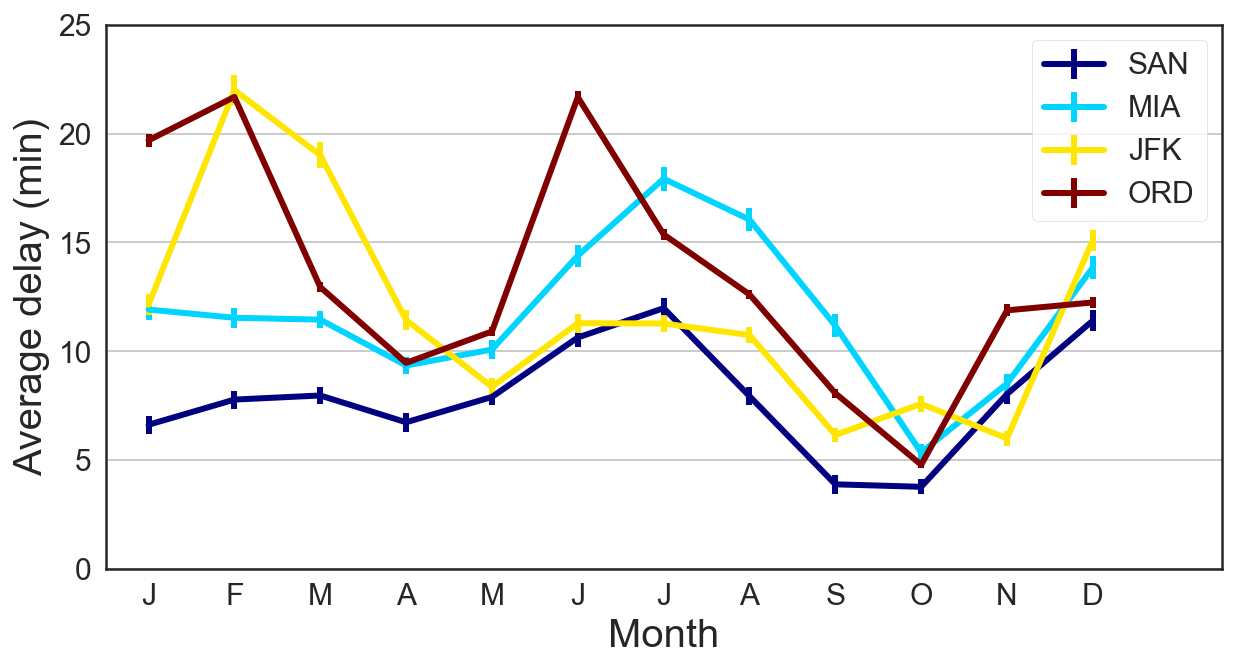

In [96]:
# Plot mean flight delay for many airports
def getcmaprgb(N, cmap):
	"""Get the RGB values of N colors across a colormap"""
	return cmap(np.linspace(0,255,N).astype(int))
from matplotlib import cm
colors = getcmaprgb(len(aps),cm.jet)

plt.figure(figsize=(10,5))  
aps = ['SAN','MIA','JFK','ORD']
for i, ap in enumerate(aps):
    means = df_mean_by_apmonth.loc[ap]['DEPARTURE_DELAY']['mean'].values
    sems = df_mean_by_apmonth.loc[ap]['DEPARTURE_DELAY']['sem'].values
    plt.errorbar(np.arange(1,13),means,yerr=sems,
             color=colors[i],label=ap,linewidth=3)
             
plt.ylabel('Average delay (min)', size=20)
plt.xlim((.5,13.5))
plt.yticks(np.arange(0,30,5), size=15)
plt.xticks(np.arange(1,13),['J','F','M','A','M','J','J','A','S','O','N','D'],size=15)
plt.legend(loc='best',fontsize=15,frameon=True)
plt.xlabel('Month',size=20)

ax = plt.gca()
ax.grid(True)
for line in ax.get_xgridlines():
    line.set_linewidth(0)
for line in ax.get_ygridlines():
    line.get_ydata
    line.set_linewidth(1)

# 1b. Weekly trends in flight delay

In [97]:
dft = flights_df[['DAY_OF_WEEK','DEPARTURE_DELAY']]
dfgb = dft.groupby('DAY_OF_WEEK')
df_mean_by_day = dfgb.agg(['mean','sem'])

plt.figure(figsize=(10,5))  
means = df_mean_by_day['DEPARTURE_DELAY']['mean'].values
sems = df_mean_by_day['DEPARTURE_DELAY']['sem'].values
plt.errorbar(np.arange(1,8),means,yerr=sems,linewidth=2,color='k')

plt.ylabel('Average delay (min)', size=20)
plt.xlim((.5,7.5))
plt.yticks(np.arange(8,12,1), size=15)
plt.xticks(np.arange(1,8),['M','Tu','W','Th','F','Sa','Su'],size=15)
plt.legend(loc='best',fontsize=15,frameon=True)
plt.xlabel('Day of week',size=20)

ax = plt.gca()
ax.grid(True)
for line in ax.get_xgridlines():
    line.set_linewidth(0)
for line in ax.get_ygridlines():
    line.get_ydata
    line.set_linewidth(1)

/Users/scott/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


# 1c. Daily trends in flight delay

In [11]:
flights_df['HOUR_DEPARTURE'] = np.floor(flights_df['SCHEDULED_DEPARTURE'].values/100).astype(int)

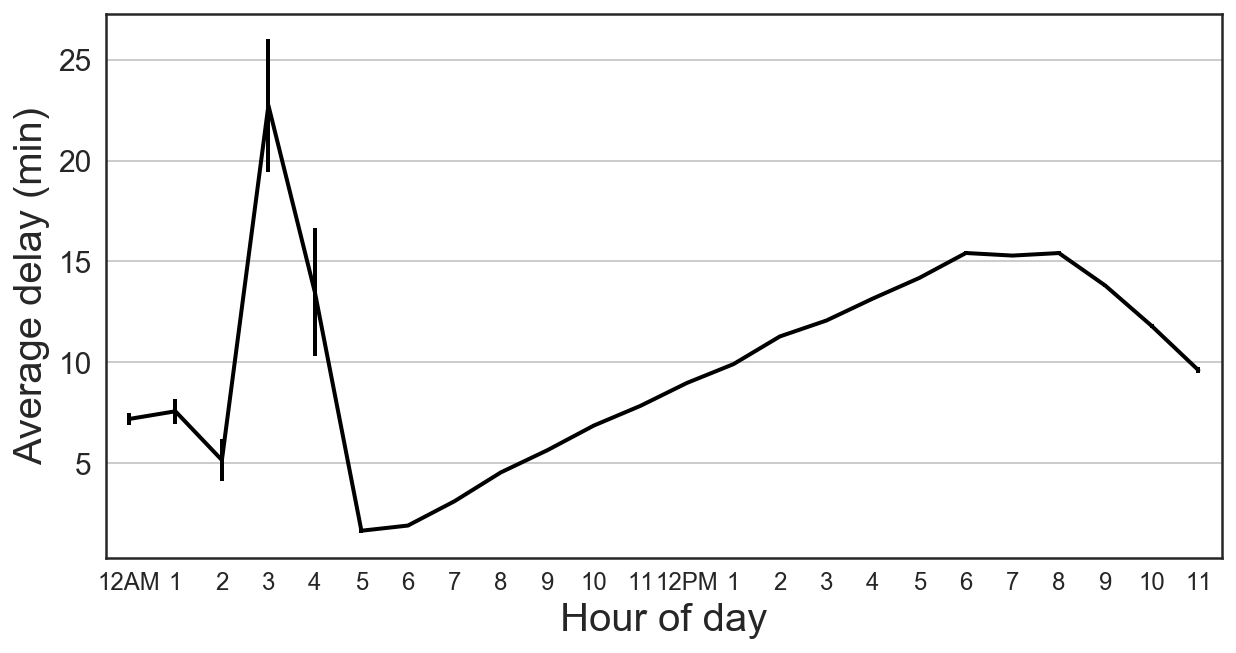

In [26]:
dft = flights_df[['HOUR_DEPARTURE','DEPARTURE_DELAY']]
dfgb = dft.groupby('HOUR_DEPARTURE')
df_mean_by_hour = dfgb.agg(['mean','sem'])
hs = df_mean_by_hour.index.values

plt.figure(figsize=(10,5))  
means = df_mean_by_hour['DEPARTURE_DELAY']['mean'].values
sems = df_mean_by_hour['DEPARTURE_DELAY']['sem'].values

plt.errorbar(hs,means,yerr=sems,linewidth=2,color='k')
plt.ylabel('Average delay (min)', size=20)
plt.xlabel('Hour of day',size=20)
plt.xlim((-.5,23.5))
plt.yticks(size=15)
plt.xticks(np.arange(24),['12AM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12PM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],size=12)


ax = plt.gca()
ax.grid(True)
for line in ax.get_xgridlines():
    line.set_linewidth(0)
for line in ax.get_ygridlines():
    line.get_ydata
    line.set_linewidth(1)

# 2. Flight delay across airports

In [100]:
dft = flights_df[['ORIGIN_AIRPORT','DEPARTURE_DELAY']]
dfgb = dft.groupby('ORIGIN_AIRPORT')
df_mean_by_ap = dfgb.agg(['mean','sem','count'])

In [101]:
# Get APs sorted by mean delay
sort_idx = np.argsort(df_mean_by_ap['DEPARTURE_DELAY']['mean'].values)
aps = np.array(list(df_mean_by_ap.index))[sort_idx]
aps_means = df_mean_by_ap['DEPARTURE_DELAY']['mean'].values[sort_idx]
aps_sems = df_mean_by_ap['DEPARTURE_DELAY']['sem'].values[sort_idx]

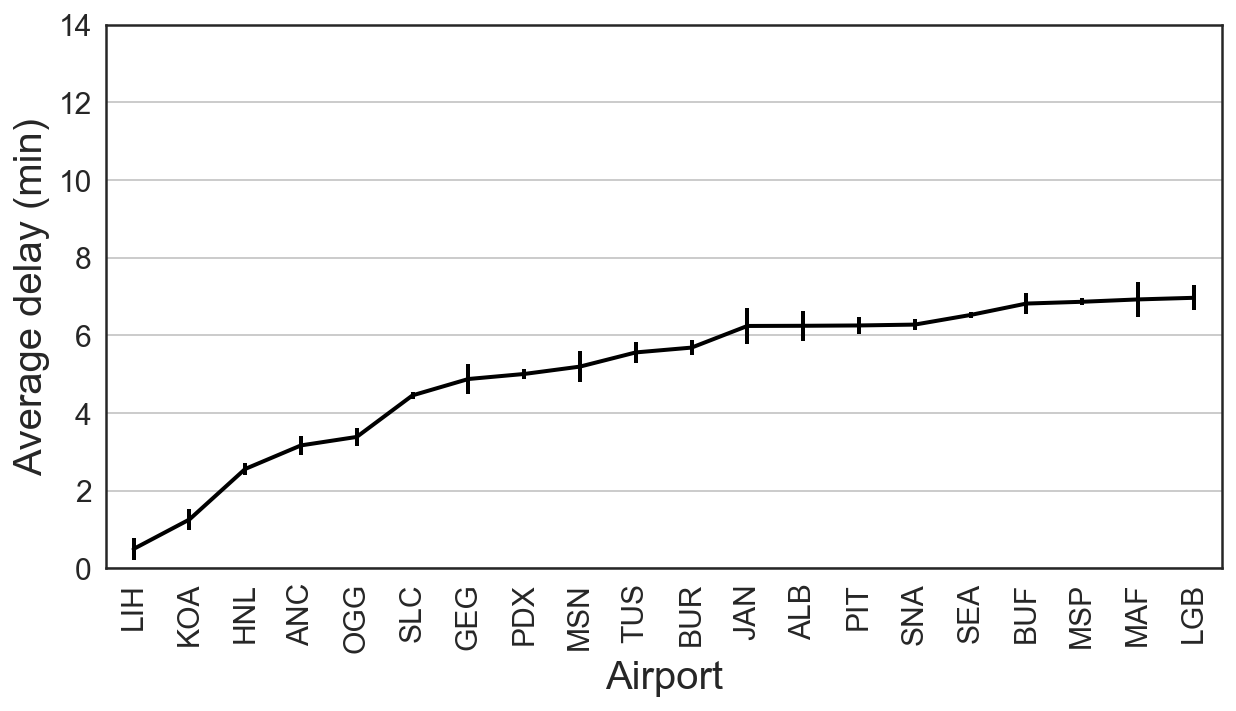

In [104]:
# Plot 20 flights least delay
N = 20
plt.figure(figsize=(10,5))  

plt.errorbar(np.arange(N),aps_means[:N],yerr=aps_sems[:N],linewidth=2,color='k')
plt.ylabel('Average delay (min)', size=20)
plt.xlabel('Airport',size=20)
plt.xlim((-.5,N-.5))
plt.yticks(size=15)
plt.xticks(np.arange(N),aps[:N],size=15,rotation='vertical')
plt.ylim((0,14))

ax = plt.gca()
ax.grid(True)
for line in ax.get_xgridlines():
    line.set_linewidth(0)
for line in ax.get_ygridlines():
    line.get_ydata
    line.set_linewidth(1)

Positive correlation between # flights departing an airport and the mean flight delay, r = 0.3   p = 0.002


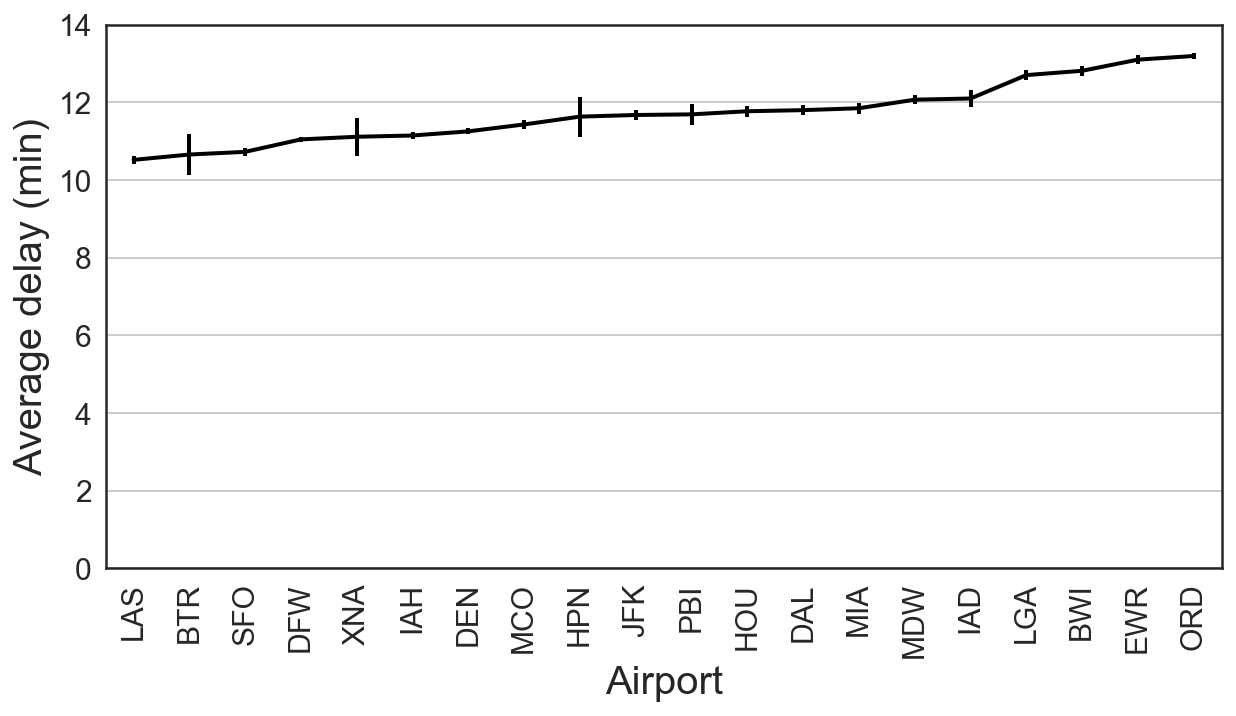

In [105]:
# Determine correltion between number of flights and the mean delay
r, p = sp.stats.spearmanr(df_mean_by_ap['DEPARTURE_DELAY']['mean'],df_mean_by_ap['DEPARTURE_DELAY']['count'])
print('Positive correlation between # flights departing an airport and the mean flight delay, r =',round(r,2),'  p =',round(p,3))

# Plot 20 flights most delayed
N = 20
plt.figure(figsize=(10,5))  

plt.errorbar(np.arange(N),aps_means[-N:],yerr=aps_sems[-N:],linewidth=2,color='k')
plt.ylabel('Average delay (min)', size=20)
plt.xlabel('Airport',size=20)
plt.xlim((-.5,N-.5))
plt.yticks(size=15)
plt.xticks(np.arange(N),aps[-N:],size=15,rotation='vertical')
plt.ylim((0,14))

ax = plt.gca()
ax.grid(True)
for line in ax.get_xgridlines():
    line.set_linewidth(0)
for line in ax.get_ygridlines():
    line.get_ydata
    line.set_linewidth(1)

# 3. Flight delays across airlines

In [68]:
# Find average delay by airline
dft = flights_df[['AIRLINE','DEPARTURE_DELAY']]
dfgb = dft.groupby('AIRLINE')
df_mean_by_al = dfgb.agg(['mean','sem','count'])

In [69]:
# Get airlines sorted by mean delay
sort_idx = np.argsort(df_mean_by_al['DEPARTURE_DELAY']['mean'].values)
als = np.array(list(df_mean_by_al.index))[sort_idx]
als_means = df_mean_by_al['DEPARTURE_DELAY']['mean'].values[sort_idx]
als_sems = df_mean_by_al['DEPARTURE_DELAY']['sem'].values[sort_idx]

In [78]:
# Get average for only SAN flights
def avg_delay_by_airline_one_airport(ap):
    gb_aph = flights_df[['AIRLINE','ORIGIN_AIRPORT','DEPARTURE_DELAY']].groupby(['ORIGIN_AIRPORT','AIRLINE'])
    mean_delays = gb_aph.agg(['mean','count','sem'])

    SAN_als = list(mean_delays.loc[ap].index)
    SAN_means = mean_delays.loc[ap]['DEPARTURE_DELAY']['mean'].values
    SAN_ss = mean_delays.loc[ap]['DEPARTURE_DELAY']['sem'].values

    N_SANals = len(SAN_als)
    SAN_als_idx = np.zeros(N_SANals)
    for i, al in enumerate(SAN_als):
        SAN_als_idx[i] = np.argwhere(als==al)[0][0]

    SAN_means = SAN_means[np.argsort(SAN_als_idx)]
    SAN_ss = SAN_ss[np.argsort(SAN_als_idx)]
    SAN_als_idx = SAN_als_idx[np.argsort(SAN_als_idx)]
    return SAN_means, SAN_ss, SAN_als_idx

SAN_means, SAN_ss, SAN_als_idx = avg_delay_by_airline_one_airport('SAN')
JFK_means, JFK_ss, JFK_als_idx = avg_delay_by_airline_one_airport('JFK')

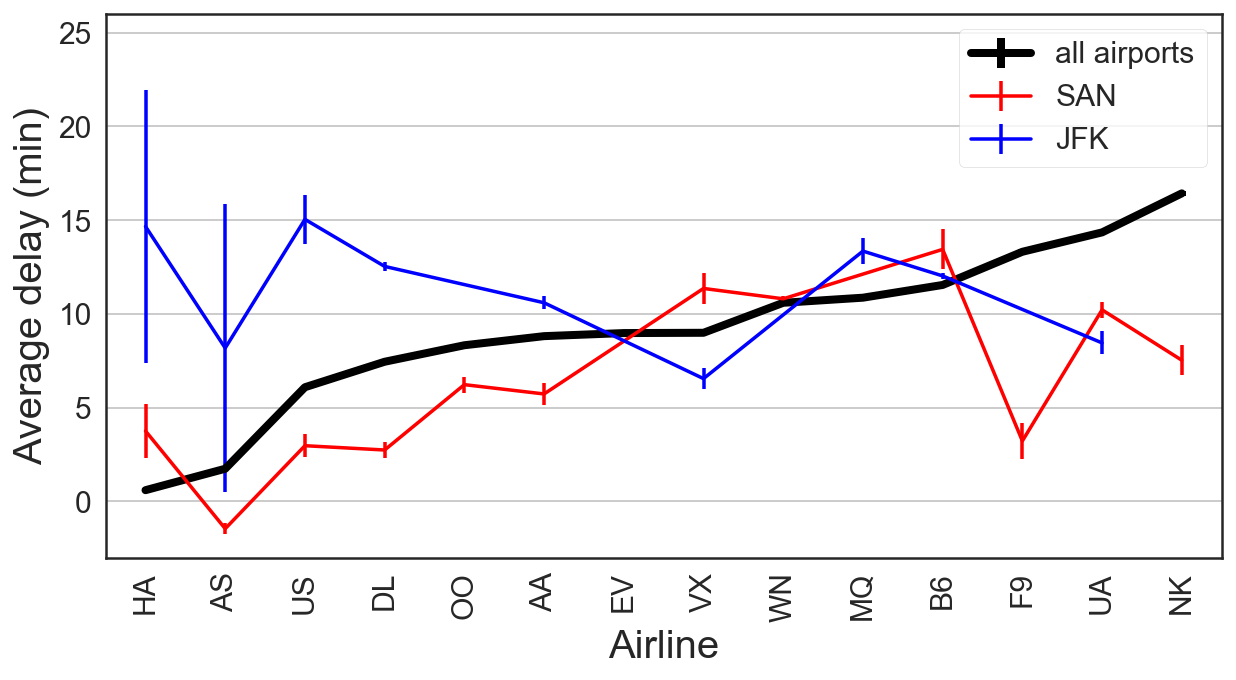

In [108]:
# Plot flight delay by airline
N = len(als)
plt.figure(figsize=(10,5))  
plt.errorbar(np.arange(N),als_means,yerr=als_sems,linewidth=4,color='k',label='all airports')
plt.errorbar(SAN_als_idx, SAN_means, yerr=SAN_ss,color='r',label='SAN')
plt.errorbar(JFK_als_idx, JFK_means, yerr=JFK_ss,color='b',label='JFK')
plt.ylabel('Average delay (min)', size=20)
plt.xlabel('Airline',size=20)
plt.xlim((-.5,N-.5))
plt.yticks(size=15)
plt.xticks(np.arange(N),als[:N],size=15,rotation='vertical')
plt.legend(loc='best',fontsize=15,frameon=True)
plt.ylim((-3,26))

ax = plt.gca()
ax.grid(True)
for line in ax.get_xgridlines():
    line.set_linewidth(0)
for line in ax.get_ygridlines():
    line.get_ydata
    line.set_linewidth(1)

In [62]:
# List airline codes
als = list(df_mean_by_al.index)
df_al, df_ap = flio.load_data_lines_and_ports()
df_al.loc[als]

AIRLINE
IATA_CODE                              
AA               American Airlines Inc.
AS                 Alaska Airlines Inc.
B6                      JetBlue Airways
DL                 Delta Air Lines Inc.
EV          Atlantic Southeast Airlines
F9               Frontier Airlines Inc.
HA               Hawaiian Airlines Inc.
MQ         American Eagle Airlines Inc.
NK                     Spirit Air Lines
OO                Skywest Airlines Inc.
UA                United Air Lines Inc.
US                      US Airways Inc.
VX                       Virgin America
WN               Southwest Airlines Co.

# 4. Flight delay by duration

In [81]:
# Compute the number of half-hours in the flight (rounded down)
flights_df['HALFHRS'] = np.floor(flights_df['SCHEDULED_TIME'].values/30).astype(int)

/Users/scott/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


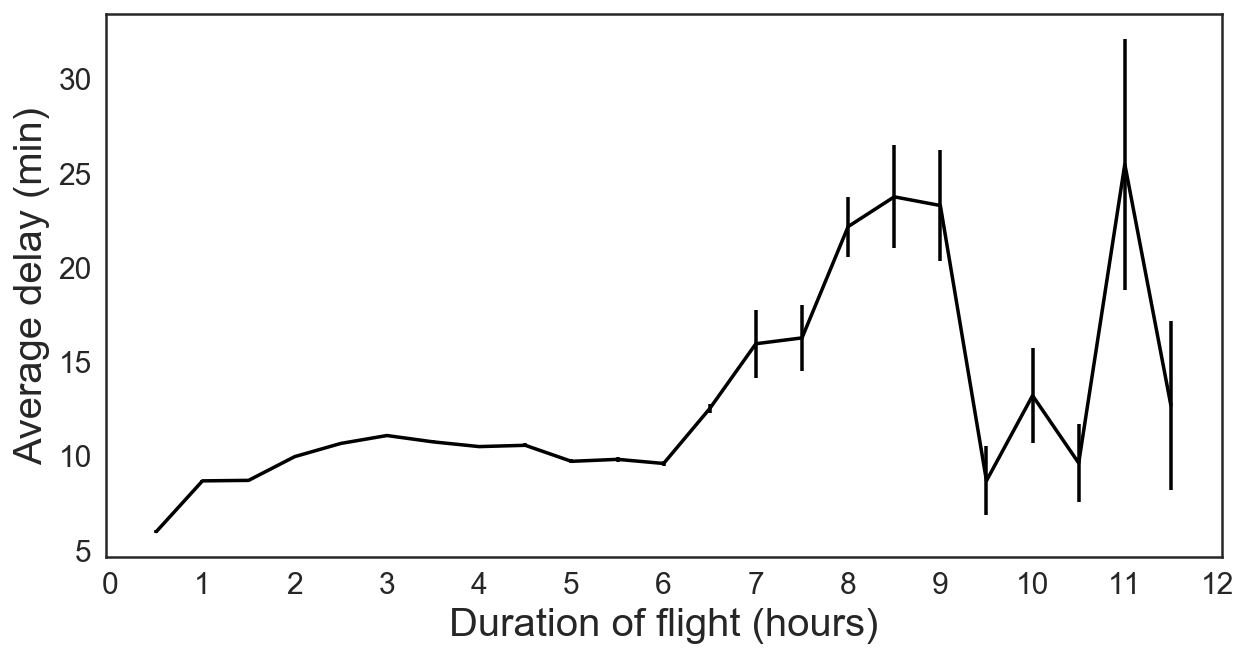

In [84]:
# Compute mean delay for each duration bin
gb_aph = flights_df[['HALFHRS','DEPARTURE_DELAY']].groupby(['HALFHRS'])
mean_delays = gb_aph.agg(['mean','sem','count'])

x = np.arange(len(hs))
hs = mean_delays.index.values
ds = mean_delays['DEPARTURE_DELAY']['mean'].values
plt.figure(figsize=(10,5))
plt.errorbar(hs/2, ds,yerr=mean_delays['DEPARTURE_DELAY']['sem'].values,color='k')
plt.xlabel('Duration of flight (hours)',size=20)
plt.ylabel('Average delay (min)', size=20)
plt.yticks(size=15)
plt.xticks(np.arange(13),size=15)
plt.legend(loc='best',fontsize=12)

### 4b. Duration effect on delay by airport

In [85]:
# Compute mean flight delay for each duration half hour separated by airport
gb_aph = flights_df[['ORIGIN_AIRPORT','HALFHRS','DEPARTURE_DELAY']].groupby(['ORIGIN_AIRPORT','HALFHRS'])
mean_delays = gb_aph.agg(['mean'])

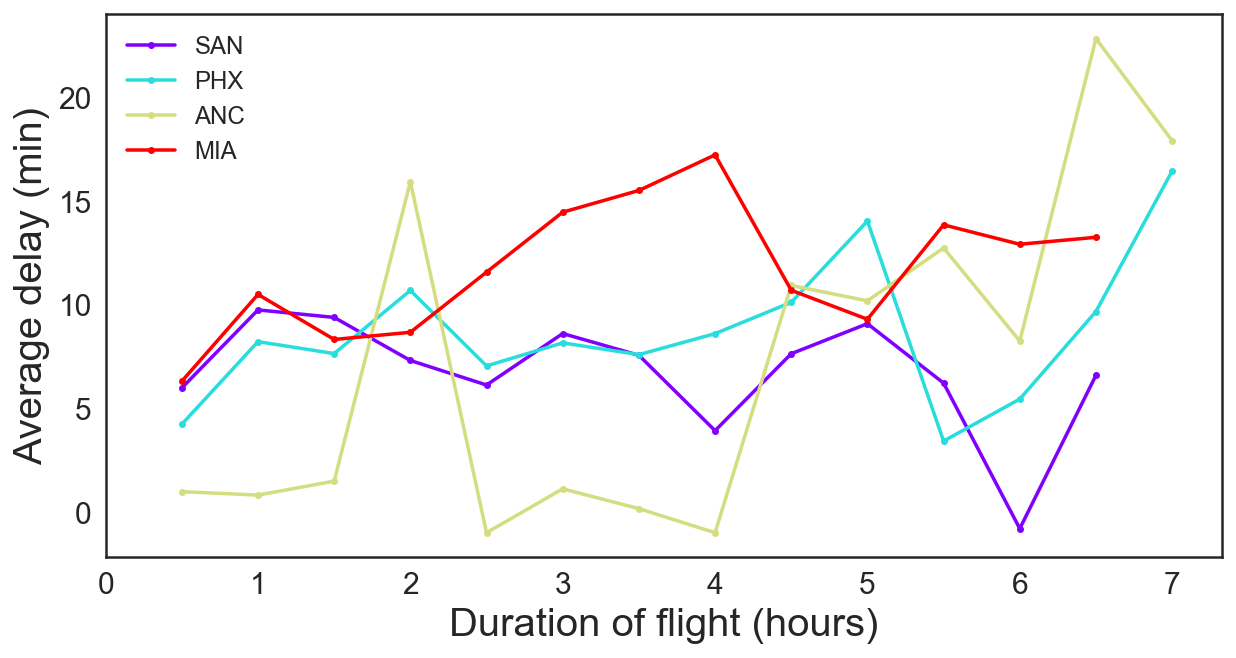

In [95]:
# Plot for many aps
aps = ['SAN','PHX','ANC','MIA']
colors = getcmaprgb(len(aps),cm.rainbow)

plt.figure(figsize=(10,5))
for i, ap in enumerate(aps):
    df_ap = mean_delays.loc[ap]
    hs = df_ap.index.values
    ds = df_ap['DEPARTURE_DELAY']['mean'].values
    plt.plot(hs/2, ds,'.-',color=colors[i],label=ap)
plt.xlabel('Duration of flight (hours)',size=20)
plt.ylabel('Average delay (min)', size=20)
plt.yticks(size=15)
plt.xticks(np.arange(8),size=15)
plt.legend(loc='best',fontsize=12)